# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


# 1. Load Dataset

In [2]:
df = pd.read_csv('./data/final_0507.csv')
# 한국 일일확진자 변수 제거
df.drop(['Unnamed: 0'], axis=1, inplace=True)

## lag 변수 생성

In [3]:
df.Date = pd.to_datetime(df.Date)
#df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

In [4]:
lag_col= list(df.columns)

In [5]:
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
    
df.dropna(inplace=True)

In [6]:
df.tail()

,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,GB_conf,...,news_lag3,covid_tr_lag1,covid_tr_lag2,covid_tr_lag3,coro_tr_lag1,coro_tr_lag2,coro_tr_lag3,target_lag1,target_lag2,target_lag3
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,0,0,476,284,7933,6,0,34037,557,6204,...,1763.0,43.0,63.0,59.0,18.0,18.0,18.0,4.0,5.0,12.0
2020-05-02,0,0,445,156,9623,13,3,29078,561,4815,...,1117.0,48.0,43.0,63.0,18.0,18.0,18.0,8.0,4.0,5.0
2020-05-03,4,0,335,295,10633,8,4,25501,564,4342,...,1266.0,43.0,48.0,43.0,18.0,18.0,18.0,8.0,8.0,4.0
2020-05-04,6,0,199,262,10581,3,2,22335,567,3990,...,1104.0,55.0,43.0,48.0,18.0,18.0,18.0,10.0,8.0,8.0
2020-05-05,0,0,318,199,10102,2,0,23976,462,4411,...,732.0,30.0,55.0,43.0,17.0,18.0,18.0,8.0,10.0,8.0


# Data Exploration

In [7]:
# 결측치 확인
df.isnull().sum().sum()

0

In [8]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['target'].shape))

전체 데이터 shape: (102, 332)
target feature shape: (102,)


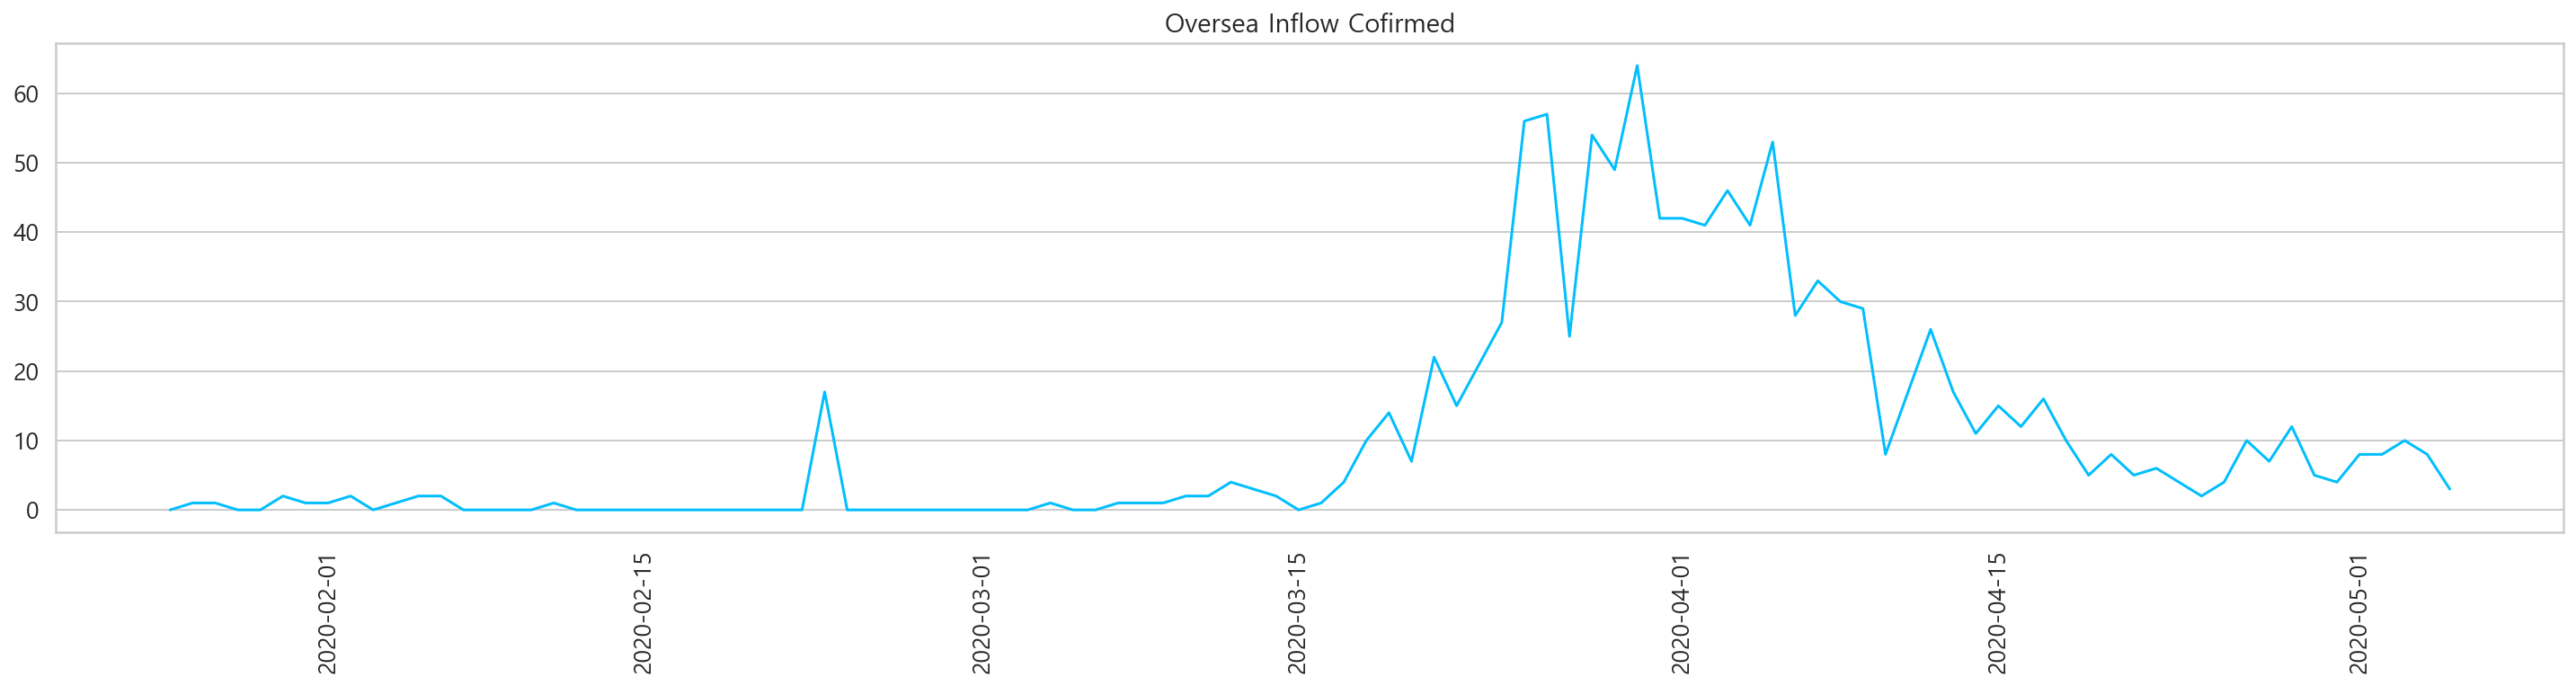

In [9]:
plt.figure(figsize=(25,5))
plt.plot(df['target'])
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')

# LSTM Model

In [10]:
X_cols = list(df.columns)
X_cols.remove('target')

In [11]:
# 테스트 데이터 수
test_data_size = 20
# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']
print(X.shape)

(102, 331)


In [12]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

ValueError: X has 331 features, but MinMaxScaler is expecting 1 features as input.

In [30]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

NameError: name 'X_train' is not defined

In [31]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res

In [ ]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)
print(X_train.shape)

In [ ]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [ ]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

# Building a Model

In [ ]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [ ]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [ ]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=200

In [ ]:
# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

In [ ]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

# Predicting daily cases

In [ ]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [ ]:
preds

In [ ]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [ ]:
pred_values

In [ ]:
pred_values_ceiled  = list(pred_values.flatten())

In [ ]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [ ]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [ ]:
score_table

In [ ]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [ ]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [ ]:
# 모델 저장
#PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
PATH = './models/{6}_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs, score.round(2))

torch.save(model, PATH)

In [ ]:
# 모델 불러오기
#PATH = './models/score84_n_features_10_n_hidden_64_n_layers_4_lr_0.0001_seq_length_1_num_epochs_250.pth'
model = torch.load(PATH)
#model.eval()

# Use all data for training

In [ ]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = df['target']

In [ ]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [ ]:
y_all

In [ ]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

In [ ]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [ ]:
# model = CoronaVirusPredictor(
#   n_features=n_features,
#   n_hidden=n_hidden,
#   seq_len=seq_length,
#   n_layers=n_layers
# )
# model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=200, lr=lr)

# Predicting future cases

In [ ]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [ ]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

In [ ]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [ ]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [ ]:
preds_

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(df['target'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();